# **Otimização - Toy Experiment: Mitigação de Crosstalk**

**Disciplina:** PPGEE0016 - Otimização

**Alunos:** André Paiva, Josias Souza, Victor Emanuel Paz

In [1]:
import sys
sys.path.insert(1, "../crosstalk/")

from time import time
import numpy as np
import pandas as pd
import glob
from matplotlib import pyplot as plt
import seaborn as sns

from functions import *
from XTconstants import *


/home/and/github/ATLAS-Crosstalk-Toy-Experiment/toy_experiment/../crosstalk/functions.py:503: SyntaxWarning: invalid escape sequence '\e'
  plotHisto(pred, y2=of, y3=ref, pathOut=pathSS, label=f'R$_\eta$', legend=legend, text=ee, fileName=fileName, xRange=RetaRange, save=save, show=show)
/home/and/github/ATLAS-Crosstalk-Toy-Experiment/toy_experiment/../crosstalk/functions.py:515: SyntaxWarning: invalid escape sequence '\p'
  plotHisto(pred, y2=of, y3=ref, pathOut=pathSS, label=f'R$_\phi$', legend=legend, text=ee, fileName=fileName, xRange=RphiRange, save=save, show=show)
/home/and/github/ATLAS-Crosstalk-Toy-Experiment/toy_experiment/../crosstalk/functions.py:527: SyntaxWarning: invalid escape sequence '\e'
  plotHisto(pred, y2=of, y3=ref, pathOut=pathSS, label=f'W$_{{\eta2}}$', legend=legend, text=ee, fileName=fileName, xRange=Weta2Range, save=save, show=show)
/home/and/github/ATLAS-Crosstalk-Toy-Experiment/toy_experiment/../crosstalk/functions.py:547: SyntaxWarning: invalid escape seq

In [2]:
def func_s(params, n, sampling_period=25, capacitance_clean=50.0, capacitance_xt=47.0):
    """
    Function to approximate samples from signal contaminated by crosstalk.

    Parameters
    ----------
    ``params``: Dictionary containing E, tau, E_x, tau_x.
    ``n``: Sample index.
    ``sampling_period``: Time distance between samples (default is 25ns).

    Returns
    -------
    Value from sample of approximated function according to given parameters.

    """
    
    clean_signal = params["E"]*cellFunction(sampling_period*(n+1) + params["tau"], capacitance_clean)
    xt_signal = params["E_x"]*XTalk(sampling_period*(n+1) + params["tau_x"], capacitance_xt)
    return clean_signal + xt_signal

In [3]:
def func_mse(samples, params, sampling_period=25, capacitance_clean=50.0, capacitance_xt=47.0):
    mse = 0
    for i in range(samples.shape[0]):
        mse += (samples[i] - func_s(params, i, sampling_period, capacitance_clean, capacitance_xt))**2
    mse /= samples.shape[0]
    return mse

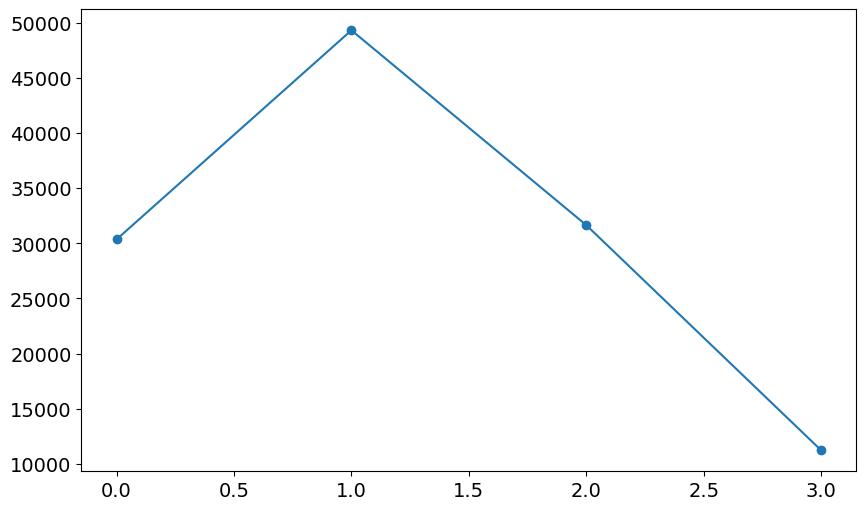

In [4]:
params = {"E": 50000, "tau": 0, "E_x": 200, "tau_x": 0}
func = [func_s(params, i) for i in range(4)]
plt.plot(func, marker='o')

<Axes: ylabel='Count'>

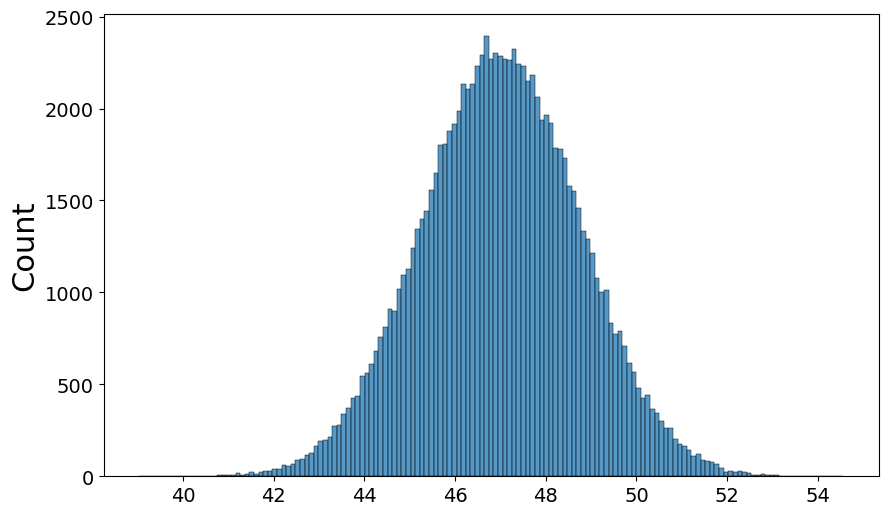

In [5]:
# Distribuição aleatória para Tau

#teste_aleatorio = np.abs(np.random.normal(loc=5, scale=5, size=100000))
teste_aleatorio =  np.random.normal(loc=47, scale=1.75, size=100000)
#teste_aleatorio =  np.abs(np.random.normal(loc=9000, scale=8000, size=100000))
teste_aleatorio.shape
sns.histplot(teste_aleatorio)

In [6]:
def genetico(samples, funcao=func_mse, sampling_period=25, populacao=100, iteracoes=50, p_recomb=0.15, p_mutacao = 0.05):
    E_init = np.abs(np.random.normal(loc=90000, scale=80000, size=populacao))
    tau_init = np.abs(np.random.normal(loc=5, scale=10, size=populacao))
    E_x_init = np.abs(np.random.normal(loc=9000, scale=8000, size=populacao))
    tau_x_init = np.abs(np.random.normal(loc=5, scale=10, size=populacao))
    x_matrix = np.stack([E_init, tau_init, E_x_init, tau_x_init], axis=1)
    avg_fitness = np.array([])
    min_fitness = np.array([])
    col = ['E', 'tau', 'E_x', 'tau_x', 'fitness', 'iter']
    df_evolution = pd.DataFrame(columns=col)
    x_pop = np.copy(x_matrix)
    time_init = time()
    best = {"E" : -np.inf, "tau": -np.inf, "E_x": -np.inf, "tau_x": -np.inf}
    for i in range(iteracoes):
        # Cálculo de Fitness e inserção no dataframe
        x_params = [{"E": candidato[0],
                     "tau": candidato[1],
                     "E_x": candidato[2],
                     "tau_x": candidato[3]} for candidato in x_pop]
        x_fitness = np.array([-funcao(samples, params, sampling_period) for params in x_params]).reshape(-1, 1)
        iter_atual = np.tile([i], x_matrix.shape[0]).reshape(-1, 1)
        df_data = np.concatenate((x_pop, x_fitness, iter_atual), axis=1)
        df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)]).reset_index(drop=True)
        # Captura de fitness médio e fitness mínimo por iteração
        avg_fitness = np.append(avg_fitness, np.mean(x_fitness))
        min_fitness = np.append(min_fitness, np.min(x_fitness))
        # Sorting Crescente
        x_sort = np.argsort(x_fitness, axis=0).reshape(-1)
        x_fitness = x_fitness[x_sort]
        x_pop = x_pop[x_sort]
        best = {"E" : x_pop[x_pop.shape[0]-1, 0],
                "tau": x_pop[x_pop.shape[0]-1, 1],
                "E_x": x_pop[x_pop.shape[0]-1, 2],
                "tau_x": x_pop[x_pop.shape[0]-1, 3]}
        # Cálculo de probabilidades de seleção
        prob_num = np.array([np.sum(np.arange(1, i+1)) for i in range(1, x_matrix.shape[0]+1)])
        prob_den = np.sum(np.arange(1, x_fitness.shape[0]+1))
        prob = prob_num/prob_den
        # Seleção de elementos
        selecao_prob = np.random.rand(np.ceil(x_fitness.shape[0]/2).astype(np.int32), 2)
        index_selecao_prob = np.searchsorted(prob, selecao_prob, side='right')
        # Recombinação
        new_pop = np.empty((0, x_pop.shape[1]))
        for j in index_selecao_prob:
            candidato1 = x_pop[j[0]]
            candidato2 = x_pop[j[1]]
            recomb_mask = np.random.rand(candidato1.shape[0])
            recomb_mask = np.array([p <= p_recomb for p in recomb_mask])
            novo_candidato1 = np.copy(candidato1)
            np.putmask(novo_candidato1, recomb_mask, candidato2)
            novo_candidato1 = novo_candidato1.reshape((1, -1))
            novo_candidato2 = np.copy(candidato2)
            np.putmask(novo_candidato2, recomb_mask, candidato1)
            novo_candidato2 = novo_candidato2.reshape((1, -1))
            new_pop = np.concatenate((new_pop, novo_candidato1, novo_candidato2), axis=0)
        new_pop = new_pop[:x_pop.shape[0]]
        # Mutação
        E_init = np.abs(np.random.normal(loc=90000, scale=80000, size=populacao))
        tau_init = np.abs(np.random.normal(loc=5, scale=10, size=populacao))
        E_x_init = np.abs(np.random.normal(loc=9000, scale=8000, size=populacao))
        tau_x_init = np.abs(np.random.normal(loc=5, scale=10, size=populacao))
        mut_gen = np.stack([E_init, tau_init, E_x_init, tau_x_init], axis=1)
        mut_mask = np.random.rand(new_pop.shape[0], new_pop.shape[1])
        mut_mask = np.array([p <= p_mutacao for p in mut_mask])
        np.putmask(new_pop, mut_mask, mut_gen)
        # Nova População
        x_pop = np.copy(new_pop)
        if(i == iteracoes - 1):
             # Cálculo de Fitness e inserção no dataframe
            x_params = [{"E": candidato[0],
                         "tau": candidato[1],
                         "E_x": candidato[2],
                         "tau_x": candidato[3]} for candidato in x_pop]
            x_fitness = np.array([-funcao(samples, params, sampling_period) for params in x_params]).reshape(-1, 1)
            iter_atual = np.tile([i], x_matrix.shape[0]).reshape(-1, 1)
            df_data = np.concatenate((x_pop, x_fitness, iter_atual), axis=1)
            df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)]).reset_index(drop=True)
            # Captura de fitness médio e fitness mínimo por iteração
            avg_fitness = np.append(avg_fitness, np.mean(x_fitness))
            min_fitness = np.append(min_fitness, np.min(x_fitness))

    elapsed_time = (time() - time_init) * 1000
    fitness_metrics = np.concatenate(([avg_fitness], [min_fitness]), axis = 0).transpose()
    df_fitness = pd.DataFrame(fitness_metrics)
    #df_fitness['Aptidao'] = ['Media', 'Minima']
        
    return best, df_evolution, df_fitness, elapsed_time

In [7]:
source   = '../crosstalk'                                              
emsData  = f'{source}/clusters'

fileEtrue  = glob.glob(f'{emsData}/*Etrue*.pkl')[0]
fileXTc    = glob.glob(f'{emsData}/*XTc*.pkl')[0]
fileXTl    = glob.glob(f'{emsData}/*XTl*.pkl')[0]

EtrueAmp   = loadSaveDict( fileEtrue, load=True )
XTcAmp     = loadSaveDict( fileXTc, load=True )
XTlAmp     = loadSaveDict( fileXTl, load=True )

In [8]:
signals_amount = 100
vectDelays = getIdxClus_mxn(cellsDelay, 7, 5)
nSamp = 4
tau_Etrue = np.abs(np.random.normal(loc=5, scale=5, size=signals_amount))
tau_XT = tau_Etrue + np.abs(np.random.normal(loc=5, scale=5, size=signals_amount))

Etrue_samp = np.array([])
XTc_samp = np.array([])
XTl_samp = np.array([])

for i in range(signals_amount):
    Etrue_samp = np.append(Etrue_samp, genCellSamples(vectDelays, tau_Etrue[i], nSamp)*(np.repeat(EtrueAmp[i].reshape(1, 25), nSamp, axis=1)))
    XTc_samp = np.append(XTc_samp, genXTcSamples(vectDelays, tau_XT[i], nSamp)*(np.repeat(XTcAmp[i].reshape(1, 25), nSamp, axis=1)))
    XTl_samp = np.append(XTl_samp, genXTlSamples(vectDelays, tau_XT[i], nSamp)*(np.repeat(XTlAmp[i].reshape(1, 25), nSamp, axis=1)))

/home/and/github/ATLAS-Crosstalk-Toy-Experiment/toy_experiment/../crosstalk/functions.py:503: SyntaxWarning: invalid escape sequence '\e'
  plotHisto(pred, y2=of, y3=ref, pathOut=pathSS, label=f'R$_\eta$', legend=legend, text=ee, fileName=fileName, xRange=RetaRange, save=save, show=show)
/home/and/github/ATLAS-Crosstalk-Toy-Experiment/toy_experiment/../crosstalk/functions.py:515: SyntaxWarning: invalid escape sequence '\p'
  plotHisto(pred, y2=of, y3=ref, pathOut=pathSS, label=f'R$_\phi$', legend=legend, text=ee, fileName=fileName, xRange=RphiRange, save=save, show=show)
/home/and/github/ATLAS-Crosstalk-Toy-Experiment/toy_experiment/../crosstalk/functions.py:527: SyntaxWarning: invalid escape sequence '\e'
  plotHisto(pred, y2=of, y3=ref, pathOut=pathSS, label=f'W$_{{\eta2}}$', legend=legend, text=ee, fileName=fileName, xRange=Weta2Range, save=save, show=show)
/home/and/github/ATLAS-Crosstalk-Toy-Experiment/toy_experiment/../crosstalk/functions.py:547: SyntaxWarning: invalid escape seq

TypeError: cellFunction() missing 1 required positional argument: 'capacitance'

In [ ]:
E_XTcl = Etrue_samp + XTc_samp + XTl_samp
E_XTcl = E_XTcl.reshape(signals_amount, 25, -1)
E_XTcl_center = E_XTcl[:100, 12, :]
E_XTcl_center.shape

In [ ]:
index = 1
best, df_evolution, df_fitness, elapsed_time = genetico(E_XTcl_center[index].reshape(-1))

df_fitness.shape

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_evolution)

In [ ]:
df_est_comparison = pd.DataFrame(data=[["E", best["E"], EtrueAmp[index, 12]],
                                 ["Tau", best["tau"], tau_Etrue[index]],
                                 ["E_x", best["E_x"], XTcAmp[index, 12]+XTlAmp[index, 12]],
                                 ["Tau_x", best["tau_x"], tau_XT[index]]],
                                 columns=["Parâmetro", "Estimado", "Esperado"])

df_est_comparison

In [ ]:
plt.plot([best["tau"] + 25,
          best["tau"] + 50,
          best["tau"] + 75,
          best["tau"] + 100], E_XTcl_center[1].reshape(-1), marker='o')

tau_int = int(best["tau"])
tau_x_int = int(best["tau_x"])

ETrue_est = np.append(np.repeat([0], tau_int), [best["E"]*cellFunction(t) for t in range(600 - tau_int)])
XT_est = np.append(np.repeat([0], tau_x_int), [best["E_x"]*XTalk(t) for t in range(600 - tau_x_int)])

signal_est = ETrue_est + XT_est

plt.plot(range(600), signal_est)
